## Background

In this notebook I'll walk through an algorithm suggested by Claude to distinguish one typeface (like `display`) from another (like `serif`) in which we calculate the magnitude of how much the pixel's intensity changes in the vertical and horizontal directions of an image, relative to the pixels in the original image. I call this algorithm "gradient ratio.

This algorithm is part of my exploration of non-ML baselines to classify text images into various typeface categories (e.g., “humanist sans,” “grotesque sans,” “script,” “display,” etc.). Once the non-ML baseline is established, I'll train a neural network for this task. This is one of many notebooks in my [TypefaceClassifier project series](https://vishalbakshi.github.io/blog/#category=TypefaceClassifier).

In [48]:
import cv2
import numpy as np
import pandas as pd
from google.colab.patches import cv2_imshow

## Load Image and Binarize It

As usual, we load the image and binarize it so it's easier to distinguish between background (black pixels) and text (white pixels).

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
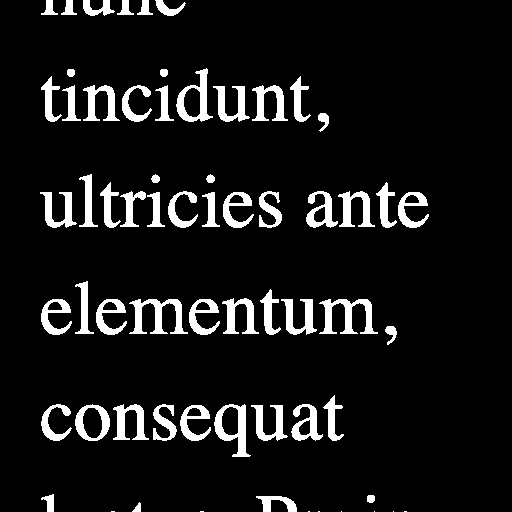

In [49]:
path = 'serif-76px.png'
img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
_, binary = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
binary

## Calculate the Vertical and Horizontal Gradient Ratios

I'll then calculate the horizontal (x) and vertical (y) gradients using `cv2.Sobel`. From the OpenCV docs:

> The Sobel Operator is a discrete differentiation operator. It computes an approximation of the gradient of an image intensity function.

To calculate horizontal gradients, when the kernel size is `3`, we apply a convolution between the following kernel and the image:

\begin{bmatrix} -1 & 0 & +1 \\ -2 & 0 & +2 \\ -1 & 0 & +1 \end{bmatrix}

For vertical gradients, when the kernel size is `3`, the we apply a convolution between the following kernel and the image:

\begin{bmatrix} -1 & -2 & -1 \\ 0 & 0 & 0 \\ +1 & +2 & +1 \end{bmatrix}

I initially tried a kernel size of 3, but it didn't seem to work well for smaller font sizes so I chose a kernel size of 1. In that case, the kernels are as follows:

horizontal gradients:


\begin{bmatrix} +1 , -1 \end{bmatrix}

vertical gradients:

\begin{bmatrix} +1 \\ -1 \end{bmatrix}

In [58]:
gradient_x = cv2.Sobel(binary, cv2.CV_64F, 1, 0, ksize=1)
gradient_y = cv2.Sobel(binary, cv2.CV_64F, 0, 1, ksize=1)

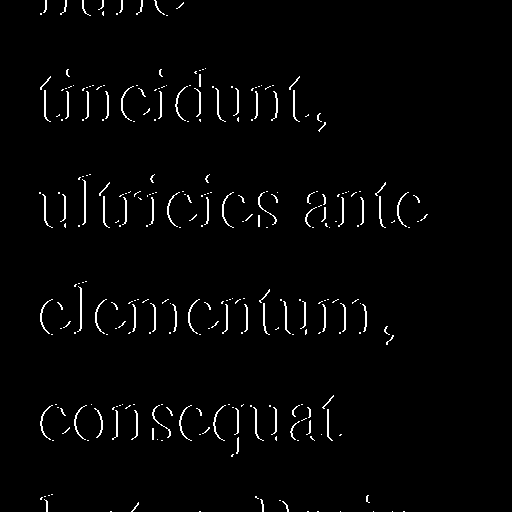

In [59]:
cv2_imshow(gradient_x)

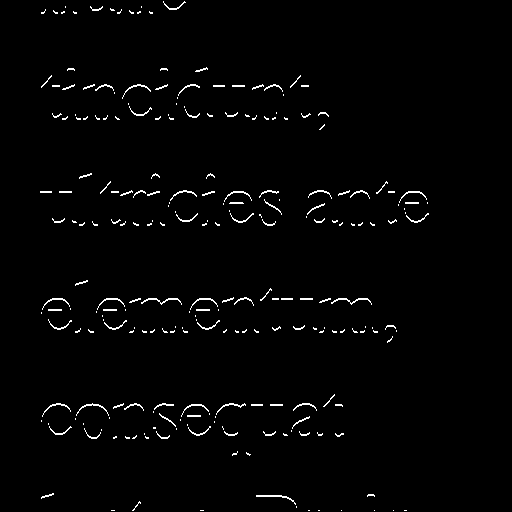

In [60]:
cv2_imshow(gradient_y)

Next I take the sum of non-zero pixels in each gradient and divide it by the sum of non-zero pixels in the original image.

In [61]:
gradient_x = np.sum(gradient_x > 0)
gradient_y = np.sum(gradient_y  > 0)
total_pixels = np.sum(binary > 0)

avg_gradient_x = gradient_x / total_pixels
avg_gradient_y = gradient_y / total_pixels

avg_gradient_x, avg_gradient_y

(0.23421579532814238, 0.19083426028921024)

The average gradient ratio is the mean value of these two gradients.

In [62]:
np.mean([avg_gradient_x, avg_gradient_y])

0.21252502780867633

## Calculating the Average Gradient Ratio for Different Images

I'll now wrap the code above into a function and apply it to a wide variety of images (of two typefaces, `display` and `serif` and 8 different font sizes).

In [63]:
def gradient_ratio(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    _, binary = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    gradient_x = np.sum(cv2.Sobel(binary, cv2.CV_64F, 1, 0, ksize=1) > 0)
    gradient_y = np.sum(cv2.Sobel(binary, cv2.CV_64F, 0, 1, ksize=1) > 0)
    total_pixels = np.sum(binary > 0)

    avg_gradient_x = gradient_x / total_pixels
    avg_gradient_y = gradient_y / total_pixels

    return np.mean([avg_gradient_x, avg_gradient_y])

Across 8 font sizes for the two typefaces, the gradient ratio is larger for the `serif` font. This makes intuitive sense---serif fonts have more changes in pixel intensity (caused by the transition from thicker stroke to thinner serif).

In [64]:
szs = [8, 18, 24, 36, 76, 240, 330, 420]
ts = ['display', 'serif']
res = []

for t in ts:
    for sz in szs:
        image_path = f"{t}-{sz}px.png"
        sr = gradient_ratio(image_path)
        res.append([t, sz, sr])

res = pd.DataFrame(res, columns=['typeface', 'font-size', 'gradient-ratio'])
res.groupby('typeface')['gradient-ratio'].agg(['mean', 'median'])

,mean,median
typeface,,
display,0.226542,0.199495
serif,0.292406,0.297558


For all font sizes, this trend is consistent: images with the `serif` font have higher gradient ratios than images with the sans serif `display` font. Again, this makes sense to me---sans serif fonts have more consistent strokes than serif fonts.

In [65]:
res.sort_values(by='font-size')

,typeface,font-size,gradient-ratio
0,display,8,0.476396
8,serif,8,0.482780
1,display,18,0.453141
9,serif,18,0.581517
2,display,24,0.381917
10,serif,24,0.500400
3,display,36,0.264844
11,serif,36,0.382591
4,display,76,0.134145
12,serif,76,0.212525


Similar to the [contour ratio algorithm](https://vishalbakshi.github.io/blog/posts/2024-09-06-typefaceclassifier-contour-ratio/) there is a clear and consistent difference in value between serif and sans serif fonts for this gradient ratio algorithm, making this a good candidate for distinguishing between typefaces.

This is also another relatively simple algorithm, and each step can be easily visualized.

I hope you enjoyed this blog post! Follow me on Twitter [@vishal_learner](https://twitter.com/vishal_learner).